<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/cronus/introtodeeplearning/blob/master/lab1/PT_Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab1/PT_Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2025 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Lab 1: Intro to PyTorch and Music Generation with RNNs

# Part 2: Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation using PyTorch. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

## 2.1 Dependencies
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

We will be using [Comet ML](https://www.comet.com/docs/v2/) to track our model development and training runs. First, sign up for a Comet account [at this link](https://www.comet.com/signup?utm_source=mit_dl&utm_medium=partner&utm_content=github
) (you can use your Google or Github account). You will need to generate a new personal API Key, which you can find either in the first 'Get Started with Comet' page, under your account settings, or by pressing the '?' in the top right corner and then 'Quickstart Guide'. Enter this API key as the global variable `COMET_API_KEY`.

In [1]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "hwMrs8LiqrVs8uxpnLfCN9Og1"

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
!pip install gcsfs==2024.9.0.post1
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 85.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.2 MB/s eta 0:00:00
ER

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [2]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [3]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train an RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.


In [4]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [5]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [6]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''
def vectorize_string(string):
  return np.array([char2idx[c] for i, c in enumerate(string)])

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:


In [7]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.


In [8]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[idx[i]:idx[i]+seq_length] for i in range(batch_size)]

    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[idx[i]+1:idx[i]+1+seq_length] for i in range(batch_size)]

    # Convert the input and output batches to tensors
    x_batch = torch.tensor(input_batch, dtype=torch.long)
    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
x_batch, y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")


Batch function works correctly!


<ipython-input-8-b64aac5d8f37>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_batch = torch.tensor(input_batch, dtype=torch.long)


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [9]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(x_batch[0], y_batch[0])):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx.item()])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx.item()])))


Step   0
  input: 82 ('|')
  expected output: 31 ('F')
Step   1
  input: 31 ('F')
  expected output: 32 ('G')
Step   2
  input: 32 ('G')
  expected output: 31 ('F')
Step   3
  input: 31 ('F')
  expected output: 1 (' ')
Step   4
  input: 1 (' ')
  expected output: 31 ('F')


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train an RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected linear [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using PyTorch's [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to define the model. Three components are used to define the model:

* [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html): Our LSTM network, with size `hidden_size`.
* [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): The output layer, with `vocab_size` outputs.

<img src="https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>



<!--
Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/> -->

### Define the RNN model

Let's define our model as an `nn.Module`. Fill in the `TODOs` to define the RNN model.


In [10]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Linear layers to define the RNN model using nn.Module'''
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Define each of the network layers
        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        '''TODO: Layer 2: LSTM with hidden_size `hidden_size`. note: number of layers defaults to 1.
         Use the nn.LSTM() module from pytorch.'''
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True) # TODO

        '''TODO: Layer 3: Linear (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.'''
        self.fc = nn.Linear(hidden_size, vocab_size) # TODO

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state with zeros
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.embedding(x)

        if state is None:
            state = self.init_hidden(x.size(0), x.device)
        out, state = self.lstm(x, state)

        out = self.fc(out)
        return out if not return_state else (out, state)



The time has come! Let's instantiate the model!

In [11]:
# Instantiate the model! Build a simple model with default hyperparameters. You
#     will get the chance to change these later.
vocab_size = len(vocab)
embedding_dim = 256
hidden_size = 1024
batch_size = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

# print out a summary of the model
print(model)

LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

We can quickly check the layers in the model, the shape of the output of each of the layers, the batch size, and the dimensionality of the output. Note that the model can be run on inputs of any length.

In [12]:
# Test the model with some sample data
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
x = x.to(device)
y = y.to(device)

#print(x.size(0))

pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       torch.Size([32, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a torch.softmax over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep. [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html#torch.multinomial) samples over a categorical distribution to generate predictions.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a repetitive loop.

Let's try this sampling out for the first example in the batch.

In [13]:
sampled_indices = torch.multinomial(torch.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
sampled_indices

array([ 6,  2, 39, 80, 10, 55, 20, 67, 44, 44, 13, 41,  1, 12, 18, 34, 16,
       64, 61, 57, 29,  3, 29,  4, 28, 22, 53, 17, 47,  6, 82, 31, 70, 80,
       71, 42, 28, 81, 34,  4, 33, 62, 72, 51, 16, 22, 55, 30, 50, 57, 72,
       44, 79, 82, 32, 41, 55, 45, 30, 66, 17, 29, 77, 59, 48, 48, 69, 61,
       24, 12,  8, 59, 39, 10, 73, 60, 52, 15, 16, 51, 53, 70, 42, 10, 50,
       28, 18, 13, 52, 65, 34, 16, 55, 39, 76, 25, 32, 66,  3, 28])

We can now decode these to see the text predicted by the untrained model:

In [14]:
print("Input: \n", repr("".join(idx2char[x[0].cpu()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '4 dB|d2 d2 e2|g4 ed|e2 e2 g2|a4 ge|!\ng2 g2 de|g2 g2 de|g2 g2 a2|b6|b2 b2 b2|b4 ag|ag ab ab|a4 gf|!\ne'

Next Char Predictions: 
 '(!Ny._8lSS1P 06I4ifbD"D#C:]5V(|FoypQCzI#HgqZ4:_EYbqSx|GP_TEk5DvdWWnf=0,dN.re[34Z]oQ.YC61[jI4_Nu>Gk"C'


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? Well, we can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (i.e., negative log likelihood loss). Specifically, we will use PyTorch's [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), as it combines the application of a log-softmax ([`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax)) and negative log-likelihood ([`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) in a single class and accepts integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's define a function to compute the loss, and then use that function to compute the loss using our example predictions from the untrained model.

In [15]:
### Defining the loss function ###

# '''TODO: define the compute_loss function to compute and return the loss between
#     the true labels and predictions (logits). '''
cross_entropy = nn.CrossEntropyLoss() # instantiates the function
def compute_loss(labels, logits):
    """
    Inputs:
      labels: (batch_size, sequence_length)
      logits: (batch_size, sequence_length, vocab_size)

    Output:
      loss: scalar cross entropy loss over the batch and sequence length
    """

    # Batch the labels so that the shape of the labels should be (B * L,)
    batched_labels = labels.view(-1)

    ''' TODO: Batch the logits so that the shape of the logits should be (B * L, V) '''
    batched_logits = logits.view(logits.size(0)*logits.size(1), logits.size(2))

    '''TODO: Compute the cross-entropy loss using the batched  next characters and predictions'''
    loss = cross_entropy(batched_logits, batched_labels)
    return loss

In [16]:
### compute the loss on the predictions from the untrained model from earlier. ###
y.shape  # (batch_size, sequence_length)
pred.shape  # (batch_size, sequence_length, vocab_size)

'''TODO: compute the loss using the true next characters from the example batch
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print(f"Prediction shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss:      {example_batch_loss.mean().item()}")

Prediction shape: torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.4261603355407715


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

In [17]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  hidden_size = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

Having defined our hyperparameters we can set up for experiment tracking with Comet. [`Experiment`](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/) are the core objects in Comet and will allow us to track training and model development. Here we have written a short function to create a new Comet experiment. Note that in this setup, when hyperparameters change, you can run the `create_experiment()` function to initiate a new experiment. All experiments defined with the same `project_name` will live under that project in your Comet interface.



In [18]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) and [`Adagrad`](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

First, we will instantiate a new model and an optimizer, and ready them for training. Then, we will use [`loss.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html), enabled by PyTorch's [autograd](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) method, to perform the backpropagation. Finally, to update the model's parameters based on the computed gradients, we will utake a step with the optimizer, using [`optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html).

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

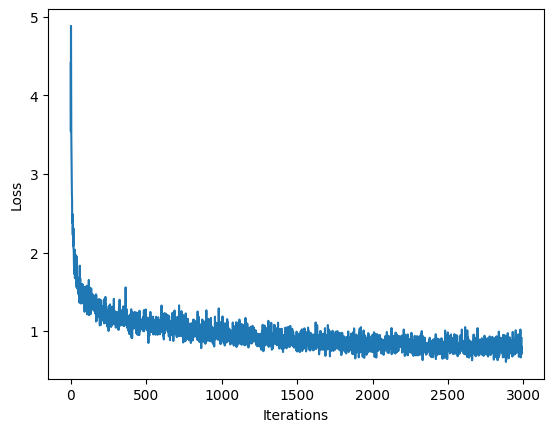

100%|██████████| 3000/3000 [01:28<00:00, 33.80it/s]
COMET INFO: Uploading 28 metrics, params and output messages


True

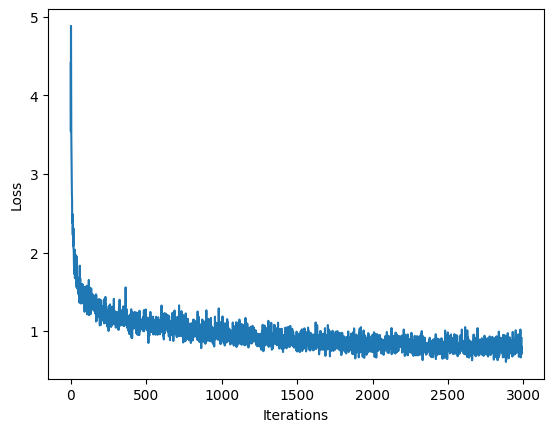

In [19]:
### Define optimizer and training operation ###

'''TODO: instantiate a new LSTMModel model for training using the hyperparameters
    created above.'''
model = LSTMModel(vocab_size, params["embedding_dim"], params["hidden_size"])

# Move the model to the GPU
model.to(device)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the PyTorch website for a list of supported optimizers.
  https://pytorch.org/docs/stable/optim.html
  Try using the Adam optimizer to start.'''
optimizer = torch.optim.Adam(model.parameters(), params["learning_rate"])

def train_step(x, y):
  # Set the model's mode to train
  model.train()

  # Zero gradients for every step
  optimizer.zero_grad()

  # Forward pass
  '''TODO: feed the current input into the model and generate predictions'''
  y_hat = model(x)

  # Compute the loss
  loss = compute_loss(y, y_hat)

  # Backward pass
  '''TODO: complete the gradient computation and update step.
    Remember that in PyTorch there are two steps to the training loop:
    1. Backpropagate the loss
    2. Update the model parameters using the optimizer
  '''
  loss.backward()
  optimizer.step()

  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])

    # Convert numpy arrays to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

    # Take a train step
    loss = train_step(x_batch, y_batch)

    # Log the loss to the Comet interface
    experiment.log_metric("loss", loss.item(), step=iter)

    # Update the progress bar and visualize within notebook
    history.append(loss.item())
    plotter.plot(history)

    # Save model checkpoint
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the final trained model
torch.save(model.state_dict(), checkpoint_prefix)
experiment.flush()


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [22]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_idx = [char2idx[start_string]]
  print(input_idx)
  input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)
  print(input_idx)

  # Initialize the hidden state
  state = model.init_hidden(input_idx.size(0), device)

  # Empty string to store our results
  text_generated = []
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
    '''TODO: evaluate the inputs and generate the next character predictions'''
    predictions, hidden_state = model(input_idx, state, return_state=True)

    # Remove the batch dimension
    predictions = predictions.squeeze(0)
    print(predictions.shape)
    print(predictions)

    '''TODO: use a multinomial distribution to sample over the probabilities'''
    input_idx = torch.multinomial(predictions, num_samples=1)[0]
    print(input_idx)

    '''TODO: add the predicted character to the generated text!'''
    # Hint: consider what format the prediction is in vs. the output
    text_generated.append(idx2char[input_idx])

  return (start_string + ''.join(text_generated))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, "X", 1000)

[49]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

We will save the song to Comet -- you will be able to find your songs under the `Audio` and `Assets & Artifacts` pages in your Comet interface for the project. Note the [`log_asset()`](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/#experimentlog_asset) documentation, where you will see how to specify file names and other parameters for saving your assets.

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

In [ ]:
# when done, end the comet experiment
experiment.end()

## 2.7 Experiment and **get awarded for the best songs**!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset?
*  Does the choice of start string significantly affect the result?

Try to optimize your model and submit your best song! **Participants will be eligible for prizes during the January 2025 offering. To enter the competition, you must upload the following to [this submission link](https://www.dropbox.com/request/U8nND6enGjirujVZKX1n):**

* a recording of your song;
* iPython notebook with the code you used to generate the song;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description.

**Name your file in the following format: ``[FirstName]_[LastName]_RNNMusic``, followed by the file format (.zip, .mp4, .ipynb, .pdf, etc). ZIP files of all three components are preferred over individual files. If you submit individual files, you must name the individual files according to the above nomenclature.**

You can also tweet us at [@MITDeepLearning](https://twitter.com/MITDeepLearning) a copy of the song (but this will not enter you into the competition)! See this example song generated by a previous student (credit Ana Heart): <a href="https://twitter.com/AnaWhatever16/status/1263092914680410112?s=20">song from May 20, 2020.</a>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Have fun and happy listening!

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)
